In [1]:
from IPython.core.debugger import set_trace

from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import pydot_ng as pydot


import sys
sys.path.append('../financial_utils/')

import keras
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

%matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt

import performance as per

C:\Users\Jon\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# DATASET

### Load and Compute Returns

In [2]:
price_table = pd.read_csv('history_files/SPY.csv')
vol_table = pd.read_csv('history_files/VIX.csv')

# Build Tick Table
tick_table = price_table[["Date","AdjClose"]]
tick_table.columns = ["Date", "Tick"]
# Get Return Table
returns = per.tick2ret(tick_table)
returns_table = pd.DataFrame({'Date':tick_table.Date[1:], 'Return': returns[:,0]})
returns_table = returns_table.set_index('Date')
# Drop columns of Vol Table
vol_table = vol_table[["Date", "Close"]]
vol_table.columns = ["Date", "Vol"]
vol_table.Vol = vol_table.Vol/100
vol_table = vol_table.set_index('Date')
# InnerJoin
retvol_table = pd.concat([returns_table,vol_table], join='inner', axis=1)


In [3]:
T_x = 10
n_fields = 2
T_y = 3
T_stride = 1

### Generate Dataset

In [4]:
def gen_dataset(T_x, T_y, n_fields, T_stride, retvol_table):
    """
    
    
    return
        x E (m, T_x)
        y E (m, T_y)
    """
    
    m = int(np.floor((returns.shape[0] - T_x) / T_stride))
    
    x = np.nan * np.ones((m-T_y*T_stride, T_x, n_fields))
    y = np.nan * np.ones((m-T_y*T_stride, T_y, n_fields))
    
    for i in range(m-T_y*T_stride):
        x[i,:,0] = retvol_table.Return[i*T_stride:i*T_stride+T_x].transpose()
        x[i,:,1] = retvol_table.Vol[i*T_stride:i*T_stride+T_x].transpose()
        y[i,:,0] = retvol_table.Return[i*T_stride+T_x:i*T_stride+T_x+T_y].transpose()
        y[i,:,1] = retvol_table.Vol[i*T_stride+T_x:i*T_stride+T_x+T_y].transpose()

    return x, y, m

In [5]:
def normalize_data(x, params=None):
    """
    
    return 
        x_norm
        x_norm_param = (mean, std)
    """
    if params == None:
        mean = np.mean(x, axis=(0,1)) 
        std = np.std(x, axis=(0,1))
    else:
        mean = params[0]
        std = params[1]
    x_norm_param = (mean, std)
    x_norm = (x - mean)/std
    
    return x_norm, x_norm_param

In [6]:
def denormalize_data(x_norm, x_norm_param):
    """"""
    
    mean = x_norm_param[0]
    std = x_norm_param[1]
    x = x_norm * std + mean
    
    return x

In [7]:
x, y, m = gen_dataset(T_x,T_y, n_fields, T_stride,retvol_table)
x, x_norm_param = normalize_data(x)
y, _ = normalize_data(y, x_norm_param)
print('Training Example: '+str(m))
print('X Shape: '+str(x.shape))
print('Y Shape: '+str(y.shape))

Training Example: 6085
X Shape: (6082, 10, 2)
Y Shape: (6082, 3, 2)


### Train / Val / Test

In [8]:
train_end = int(m * 0.7)

val_end = train_end + int(0.15 * m)

x_train = x[0:train_end]
x_val = x[train_end:val_end]
x_test = x[val_end:]

y_train = y[0:train_end]
y_val = y[train_end:val_end]
y_test = y[val_end:]

# Keras Model

### Encoder- Decoder

In [9]:
keras.backend.clear_session()

n_a = 100

encoder_LSTM = keras.layers.LSTM(units = n_a, return_state=True)
decoder_LSTM = keras.layers.LSTM(units = n_a, return_state=True, return_sequences=True)

flatter = keras.layers.Flatten()
dense = keras.layers.Dense(units = 100, activation='tanh')
relu_out = keras.layers.Dense(units = n_fields, activation='tanh')
concatenator = keras.layers.Lambda(lambda x: keras.backend.stack(x, axis=1))
last_slicor = keras.layers.Lambda(lambda x: x[:,-2:-1,:])

In [10]:
def define_model(T_x, T_y, n_fields, n_a):
    
    x_input = keras.layers.Input(shape=(T_x, n_fields))
    output_seq = list()
    
    _, encoder_h, encoder_c = encoder_LSTM(x_input)  
    
    decoder_input = keras.layers.Input(shape=(1,n_a))
    deco_input = decoder_input
    decoder_h = encoder_h
    decoder_c = encoder_c
    
    for _ in range(T_y):
        decoder_outputs, decoder_h, decoder_c = decoder_LSTM(deco_input, initial_state=[decoder_h, decoder_c])
        decoder_outputs_flat = flatter(decoder_outputs)
        out = dense(decoder_outputs_flat)
        out = relu_out(out)
        
        output_seq.append(out)
        deco_input = decoder_outputs
        
    output_seq = concatenator(output_seq)
    model = keras.models.Model(inputs=[x_input, decoder_input], outputs=output_seq)
    return model

In [11]:
model = define_model(T_x, T_y, n_fields, n_a)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10, 2)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1, 100)       0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 100), (None, 41200       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 1, 100), (No 80400       input_2[0][0]                    
                                                                 lstm_1[0][1]                     
          

In [12]:
optim = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optim, loss='mean_squared_error', metrics=['accuracy'])

In [13]:
decoder_in = np.zeros((x_train.shape[0],1,n_a))
model.fit(x=[x_train,decoder_in], y=y_train, shuffle=True, epochs = 10)

Epoch 1/10
4259/4259 [==============================] - 6s 1ms/step - loss: 0.7853 - acc: 0.7605
Epoch 2/10
4259/4259 [==============================] - 2s 445us/step - loss: 0.7815 - acc: 0.7591
Epoch 3/10
4259/4259 [==============================] - 2s 444us/step - loss: 0.7738 - acc: 0.7595
Epoch 4/10
4259/4259 [==============================] - 2s 445us/step - loss: 0.7733 - acc: 0.7596
Epoch 5/10
4259/4259 [==============================] - 2s 446us/step - loss: 0.7722 - acc: 0.7609
Epoch 6/10
4259/4259 [==============================] - 2s 446us/step - loss: 0.7728 - acc: 0.7592
Epoch 7/10
4259/4259 [==============================] - 2s 445us/step - loss: 0.7723 - acc: 0.7605
Epoch 8/10
4259/4259 [==============================] - 2s 446us/step - loss: 0.7735 - acc: 0.7596
Epoch 9/10
4259/4259 [==============================] - 2s 448us/step - loss: 0.7721 - acc: 0.7601
Epoch 10/10
4259/4259 [==============================] - 2s 449us/step - loss: 0.7708 - acc: 0.7583


In [14]:
decoder_in = np.zeros((x_test.shape[0],1,n_a))
model.evaluate(x=[x_test,decoder_in], y=y_test)

911/911 [==============================] - 1s 664us/step


[0.26242519284135424, 0.8152213702479256]

### Visualization

In [33]:
indexes = np.random.randint(0,x_test.shape[0], size=1)
x_in = x_test[indexes,:,:]
decoder_in = np.zeros((x_in.shape[0],1,n_a))
y_true = y_test[indexes,:,:]
y_pred = model.predict(x=[x_in,decoder_in])
y_pred_denorm = denormalize_data(y_pred, x_norm_param)
print('X:')
print(denormalize_data(x_in,x_norm_param))
print('Y:')
print(denormalize_data(y_true,x_norm_param))
print('LSTM Out:')
print(y_pred)
print('Y pred:')
print(y_pred_denorm)

X:
[[[ 0.02205701  0.18709999]
  [ 0.0045039   0.1874    ]
  [ 0.01060205  0.1438    ]
  [ 0.00249557  0.1474    ]
  [-0.002305    0.1417    ]
  [ 0.0007855   0.1448    ]
  [ 0.00780278  0.1337    ]
  [-0.00187834  0.1372    ]
  [ 0.00514073  0.1335    ]
  [-0.00223757  0.1285    ]]]
Y:
[[[0.00755146 0.1242    ]
  [0.00195325 0.1241    ]
  [0.000544   0.1243    ]]]
LSTM Out:
[[[-0.05794261 -0.8110568 ]
  [-0.03864247 -0.79767996]
  [-0.02835706 -0.7756126 ]]]
Y pred:
[[[-2.62662594e-04  1.31060060e-01]
  [-3.63776278e-05  1.32149726e-01]
  [ 8.42139243e-05  1.33947315e-01]]]


<IPython.core.display.Javascript object>


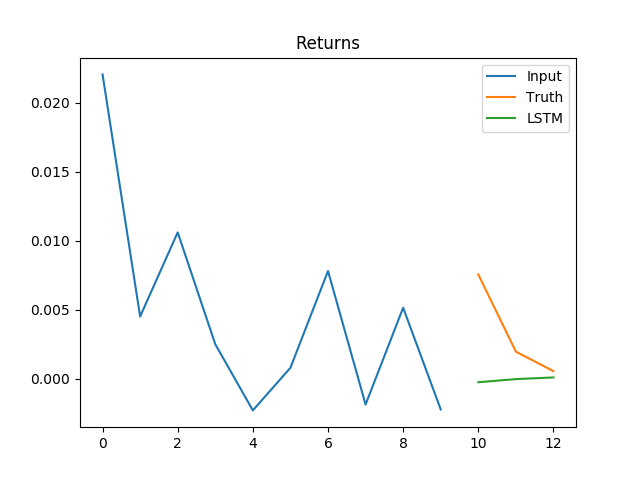

<IPython.core.display.Javascript object>


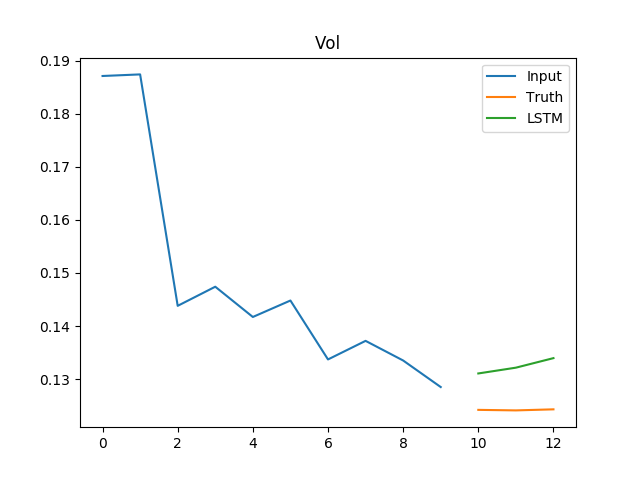

In [34]:
x_in_returns = denormalize_data(x_in,x_norm_param)[:,:,0].transpose()
x_in_vol = denormalize_data(x_in,x_norm_param)[:,:,1].transpose()
y_true_returns = denormalize_data(y_true,x_norm_param)[:,:,0].transpose()
y_true_vol = denormalize_data(y_true,x_norm_param)[:,:,1].transpose()
y_pred_returns = denormalize_data(y_pred,x_norm_param)[:,:,0].transpose()
y_pred_vol = denormalize_data(y_pred,x_norm_param)[:,:,1].transpose()
plt.figure()
plt.plot(range(0,T_x), x_in_returns, label='Input')
plt.plot(range(T_x, T_x+T_y), y_true_returns, label='Truth')
plt.plot(range(T_x, T_x+T_y), y_pred_returns, label='LSTM')
plt.title('Returns')
plt.legend()

plt.figure()
plt.plot(range(0,T_x), x_in_vol, label='Input')
plt.plot(range(T_x, T_x+T_y), y_true_vol, label='Truth')
plt.plot(range(T_x, T_x+T_y), y_pred_vol, label='LSTM')
plt.title('Vol')
plt.legend()

## SNIPPETS

### Norm - Denorm Check

In [ ]:
a, b , m = gen_dataset(T_x,T_y,T_stride,retvol_table)
x, x_norm_param = normalize_data(a)
y, _ = normalize_data(b, x_norm_param)
x = denormalize_data(x, x_norm_param)
y = denormalize_data(y, x_norm_param)

plt.figure()
plt.hist((b-y).flatten(), 100)